In [432]:
%pip install numpy matplotlib graphviz
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [433]:
def f(x):
    return 3*x**2 - 4*x + 5

In [434]:
f(3.0)

20.0

In [435]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [436]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

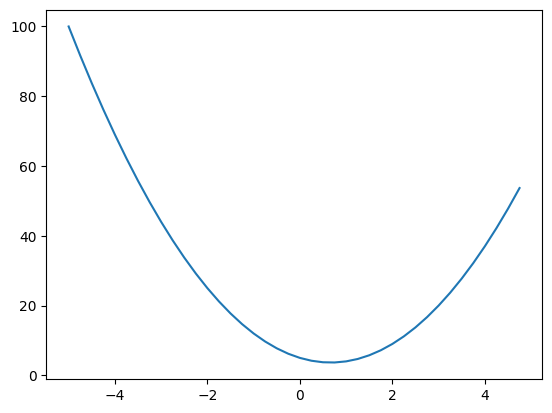

In [437]:
plt.plot(xs, ys)

In [438]:
h = 0.00001
x = -3.0
(f(x+h) - f(x))/h


-21.999970000052823

In [439]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [440]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
b+=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [441]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only int and float exponents are supported'
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + -other

    def tanh(self):
        x = self.data
        t = math.tanh(x)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self,), 'exp')
        def _backward():
            self.grad += e * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        


In [442]:
a = Value(2.0, label='a')
a+=1

In [443]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'  
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f
L


Value(data=-8.0)

In [444]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f'{n.label} | data {n.data:.4f} | grad {n.grad:.4f}', shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for a, b in edges:
        dot.edge(str(id(a)), str(id(b)) + b._op)
 
    return dot

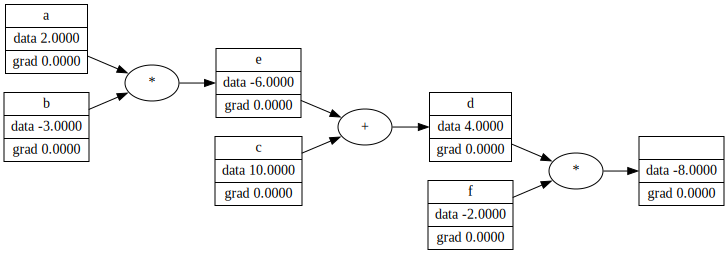

In [445]:
draw_dot(L)

In [446]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label='e'
d = e + c; d.label = 'd'
L = d*f

print(L.data)

-8.0


In [447]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0


dL / de = -2.0
e = a*b
de / da? b

dL / da = (dL / de) * (de / da) = -2.0 * 1.0 = -2.0

In [448]:
#dL / dc
#dd / dc  = 1.0 
#dd/de = 1.0
# d = c+e

# WANT:
#dL / dc

#KNOW:
#dL / dd
#dd / dc

# dL / dc = (dL / dd) * (dd / dc)

In [449]:
c.grad = -2.0
e.grad = -2.0

In [450]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [451]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'  
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a*b; e.label='e'  
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

-1.9999999999953388


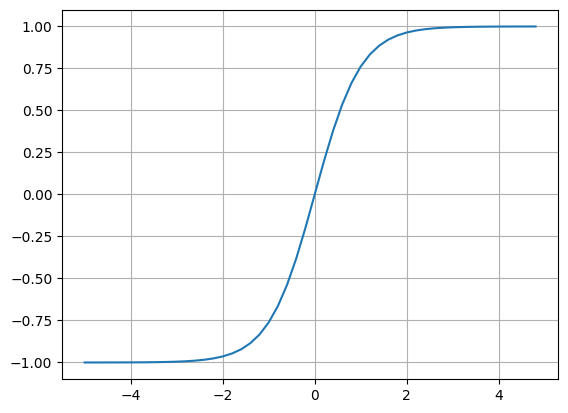

In [452]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

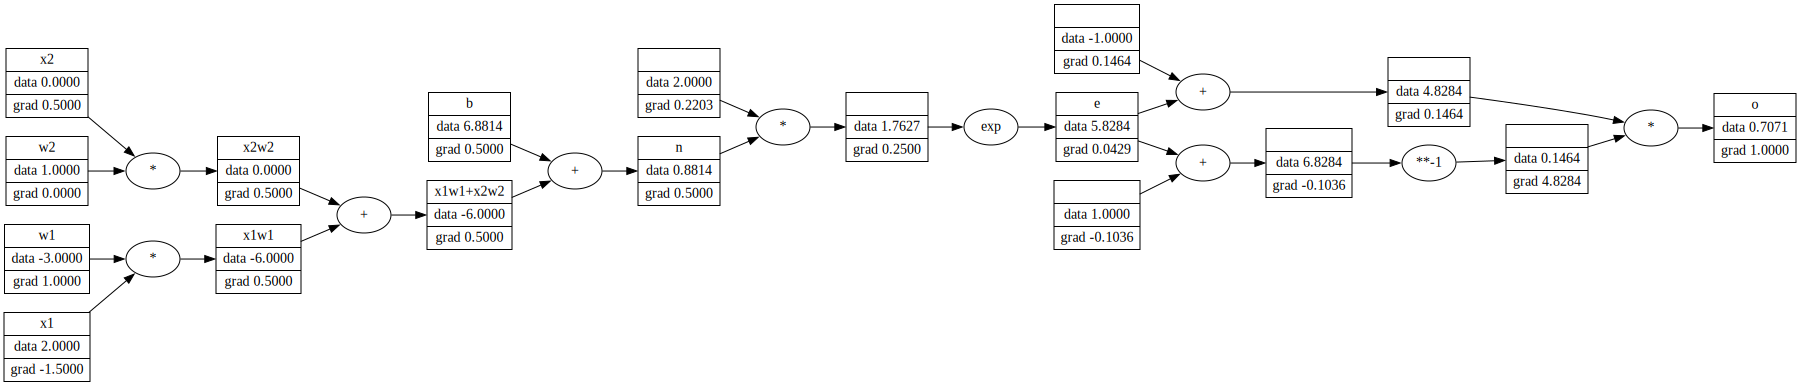

In [453]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

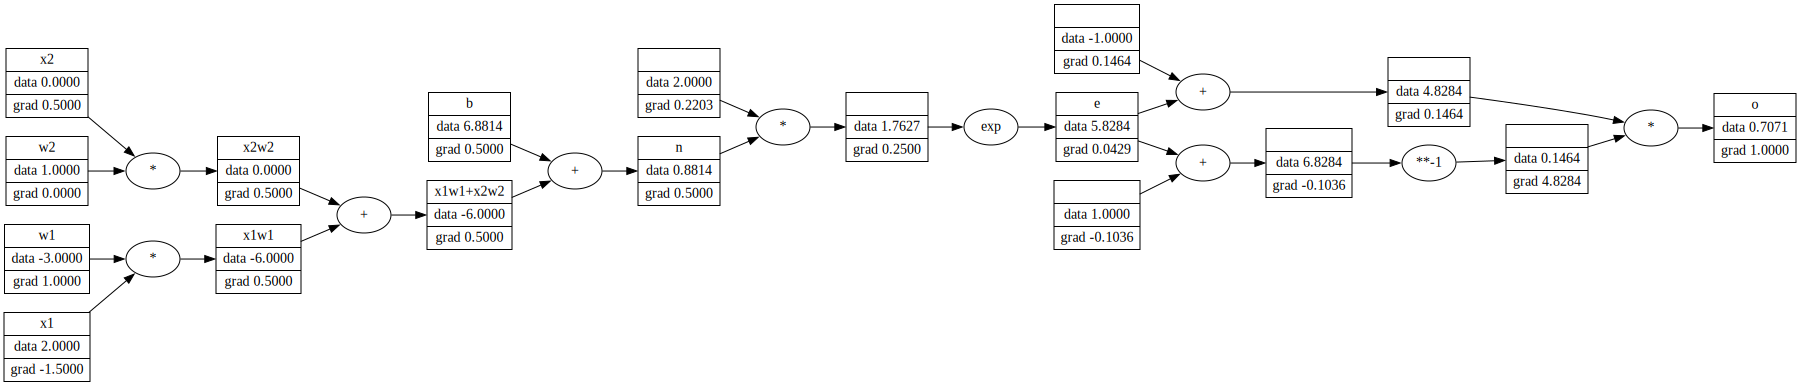

In [454]:
o.grad = 1.0

draw_dot(o)

In [455]:
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()
o.backward()

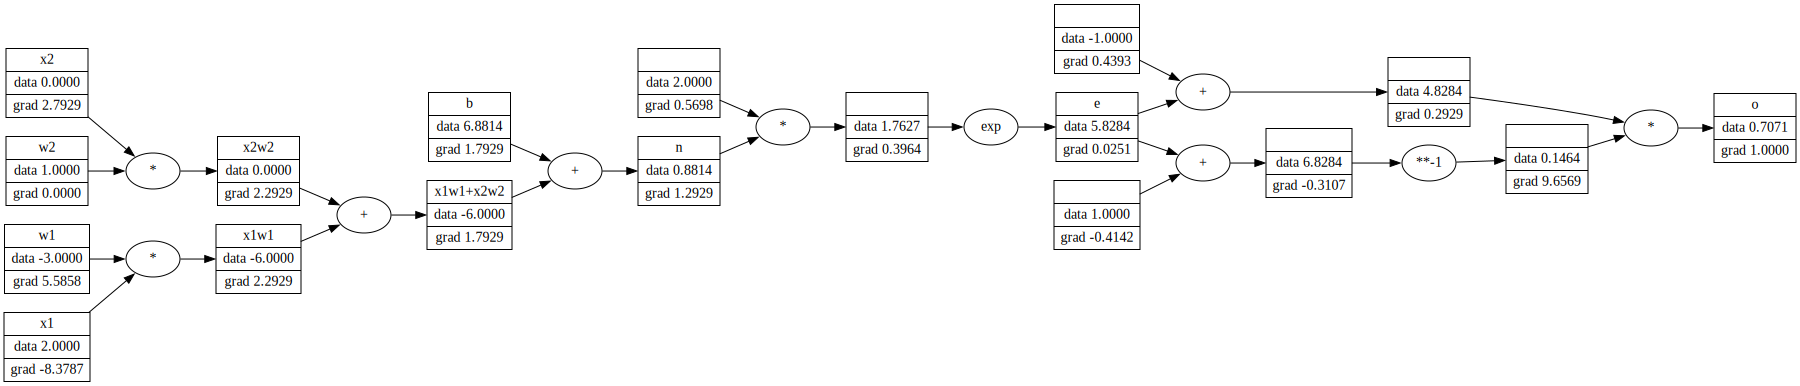

In [456]:
# o = tanh(n)
# do / dn = 1 - o**2 
# n.grad = 1 - o.data**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad
# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# #times
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data
draw_dot(o)

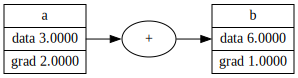

In [457]:
a = Value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

In [458]:
%pip install torch
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(x1.grad.item(), "x1")
print(x2.grad.item(), "x2")
print(w1.grad.item(), "w1")
print(w2.grad.item(), "w2")

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
0.7071066904050358
-1.5000003851533106 x1
0.5000001283844369 x2
1.0000002567688737 w1
0.0 w2


In [553]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label=f'w{i}') for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9446936185656966)

In [555]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, 1.0, -1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9446936185656966),
 Value(data=0.8242298718847293),
 Value(data=0.7312592075787152),
 Value(data=0.930150526304767)]

In [579]:
for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for yout, ygt in zip(ypred, ys))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data -= 0.05 * p.grad

    print(k, loss.data)

0 0.0012934187524332162
1 0.0012904114645992876
2 0.0012874180609454442
3 0.0012844384452866489
4 0.0012814725223268234
5 0.0012785201976486427
6 0.0012755813777032968
7 0.0012726559698006106
8 0.0012697438820991145
9 0.0012668450235963804
10 0.0012639593041193899
11 0.0012610866343151362
12 0.00125822692564125
13 0.0012553800903568617
14 0.0012525460415134708
15 0.0012497246929460502
16 0.0012469159592641817
17 0.0012441197558433837
18 0.0012413359988164875
19 0.001238564605065209


In [580]:
ypred

[Value(data=0.980599260876501),
 Value(data=-0.9869966840356202),
 Value(data=0.988605731610521),
 Value(data=-0.9762668934118146)]